## Load-cell testing data visualization & altering

In [11]:
import pickle
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import scienceplots

import os

import numpy as np

In [12]:
# Plot function
def plot_dict(d, xlabel='Time (ms)', ylabel='Force (N)', FILTER = False):
    plt.figure()
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    
    color=iter(cm.tab20(np.linspace(0,1,len(d))))
    for key in d.keys():
        c=next(color)
        this_data = np.concatenate(d[key])
        # remove force=0 data
        if FILTER:
            this_data = this_data[this_data[:,1]!=0]
        plt.scatter(this_data[:,0], this_data[:,1], label=key, color=c)
    plt.legend()
    plt.show()

In [13]:
# Solve friction
def max_freq_force(d, key):
    out = []
    data = d[key]
    for i in range(1,len(data)):
        trial = data[i]
        trial = trial[trial[:,1]!=0]
        # find the minimum force (static friction)
        min_force = np.min(trial[:,1])
        # solve most common force (kinetic friction)
        check_forces = np.linspace(min_force, 0, 100)
        max_count = 0
        freq_force = 0
        for force in check_forces:
            num_forces = np.sum(np.abs((trial[:,1] - force)) < 0.03*np.abs(min_force))
            if num_forces > max_count:
                max_count = num_forces
                freq_force = force
        # append to output
        out.append([min_force, freq_force])
    return out

def solve_friction(d):
    # dictionary, d, contains time and force data
    # output dictionary will contain the friction coefficient
    out = {}
    # keys contain the normal force (mass)
    for key in d.keys():
        # get the force data
        min_ss_forces = max_freq_force(d, key)
        # get the mass from the key
        mass = key.split('_')[0][:-2]
        norm_force = float(mass)*-9.81
        # calculate the friction coefficient
        coeffs = np.array(min_ss_forces)/norm_force
        med_static = np.median(coeffs[:,0])
        med_kinetic = np.median(coeffs[:,1])
        out[key] = [med_static, med_kinetic]
    return out


        

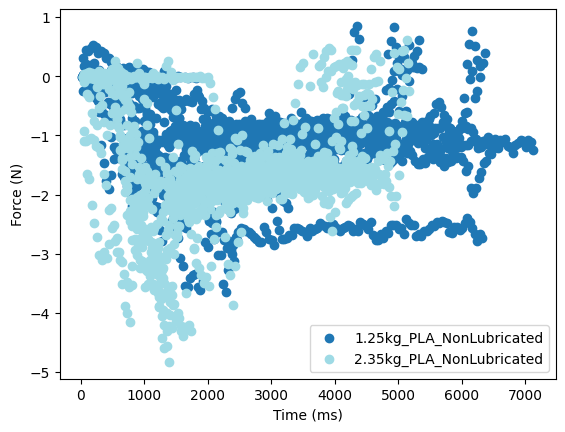

In [14]:
# MAIN: Load & PLot data
dict_name = '3_12_force_dict.pkl'
with open(dict_name, 'rb') as f:
    force_dict = pickle.load(f)

plot_dict(force_dict, FILTER=True)

15


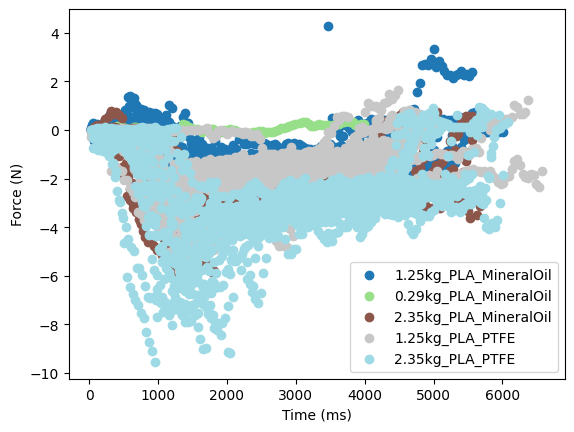

In [15]:
# MAIN: Load & PLot data
dict_name = '3_13_force_dict.pkl'
with open(dict_name, 'rb') as f:
    force_dict = pickle.load(f)

print(len(force_dict[list(force_dict.keys())[-1]]))

plot_dict(force_dict, FILTER=True)

15


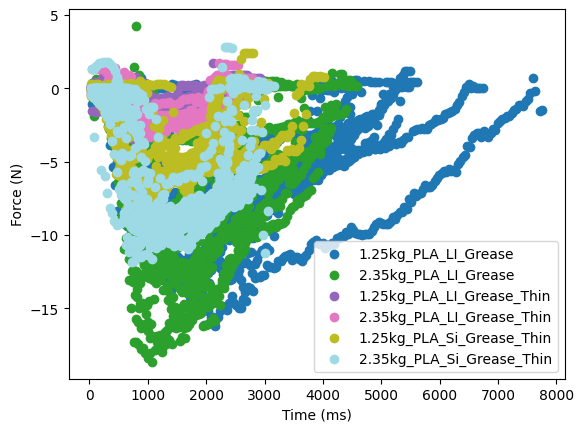

In [16]:
# MAIN: Load & PLot data
dict_name = '3_18_force_dict.pkl'
with open(dict_name, 'rb') as f:
    force_dict = pickle.load(f)
last= force_dict[list(force_dict.keys())[-1]]
last_dict = {}
last_dict[list(force_dict.keys())[-1]] = last
print(len(last))

plot_dict(force_dict, FILTER=True)
# plot_dict(last_dict, FILTER=True)

In [17]:
# create a single, cohesive, force dict:
input_names = ['3_12_force_dict.pkl', '3_13_force_dict.pkl', '3_18_force_dict.pkl']
force_dict = {}
for name in input_names:
    with open(name, 'rb') as f:
        temp_dict = pickle.load(f)
    for key in temp_dict.keys():
        if key in force_dict.keys():
            force_dict[key].append(temp_dict[key])
        else:
            force_dict[key] = temp_dict[key]

# remove entries with 1 or less trials
for key in list(force_dict.keys()):
    if len(force_dict[key]) < 2:
        del force_dict[key]

In [18]:
print(force_dict.keys())
for key in force_dict.keys():
    print(len(force_dict[key]))

dict_keys(['1.25kg_PLA_NonLubricated', '2.35kg_PLA_NonLubricated', '1.25kg_PLA_MineralOil', '2.35kg_PLA_MineralOil', '1.25kg_PLA_PTFE', '2.35kg_PLA_PTFE', '1.25kg_PLA_LI_Grease', '2.35kg_PLA_LI_Grease', '1.25kg_PLA_LI_Grease_Thin', '2.35kg_PLA_LI_Grease_Thin', '1.25kg_PLA_Si_Grease_Thin', '2.35kg_PLA_Si_Grease_Thin'])
15
15
15
15
15
15
15
15
15
15
16
15


In [19]:
# pickle.dump(force_dict, open('PLA_force_dict.pkl', 'wb'))

In [20]:
friction = solve_friction(force_dict)
# print each key and the friction coefficients
for key in friction.keys():
    print(f'{key}, {friction[key][0]:.2f}, {friction[key][1]:.2f}')

1.25kg_PLA_NonLubricated, 0.19, 0.08
2.35kg_PLA_NonLubricated, 0.17, 0.07
1.25kg_PLA_MineralOil, 0.21, 0.13
2.35kg_PLA_MineralOil, 0.20, 0.10
1.25kg_PLA_PTFE, 0.40, 0.10
2.35kg_PLA_PTFE, 0.33, 0.12
1.25kg_PLA_LI_Grease, 0.89, 0.68
2.35kg_PLA_LI_Grease, 0.62, 0.01
1.25kg_PLA_LI_Grease_Thin, 0.14, 0.09
2.35kg_PLA_LI_Grease_Thin, 0.13, 0.10
1.25kg_PLA_Si_Grease_Thin, 0.61, 0.43
2.35kg_PLA_Si_Grease_Thin, 0.44, 0.34


In [21]:
# combine friction values for each material
combined_vals = {}
for key in friction.keys():
    material_vals = key.split('_')[1:]
    material = '_'.join(material_vals)
    if material in combined_vals.keys():
        combined_vals[material].append(friction[key])
    else:
        combined_vals[material] = [friction[key]]

mat_friction = {}
# calculate the average friction values for each material
for key in combined_vals.keys():
    vals = np.array(combined_vals[key])
    static = np.mean(vals[:,0])
    kinetic = np.mean(vals[:,1])
    mat_friction[key] = [static, kinetic]

# print the average friction values for each material to 2 decimal places, sorted by static friction
for key in sorted(mat_friction.keys(), key=lambda x: mat_friction[x][0]):
    print(f'{key}: {mat_friction[key][0]:.2f}, {mat_friction[key][1]:.2f}')



PLA_LI_Grease_Thin: 0.14, 0.09
PLA_NonLubricated: 0.18, 0.08
PLA_MineralOil: 0.21, 0.11
PLA_PTFE: 0.36, 0.11
PLA_Si_Grease_Thin: 0.52, 0.39
PLA_LI_Grease: 0.75, 0.35


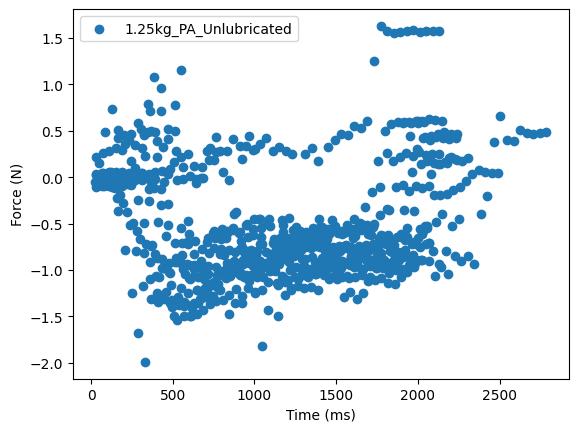

In [22]:
# load today's dict
today_dict = '3_25_force_dict.pkl'
with open(today_dict, 'rb') as f:
    this_dict = pickle.load(f)

plot_dict(this_dict, FILTER=True)
this_fric = solve_friction(this_dict)

In [23]:
this_fric

{'1.25kg_PA_Unlubricated': [np.float64(0.11253822629969418),
  np.float64(0.06589853684654909)]}